# Instrumental Variables

In [79]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [80]:
from src.utils import *

In [81]:
n = 10_000
np.random.seed(1)

N = np.arange(0, n)
df = pd.DataFrame({
    "budget": np.random.exponential(100, n),
    "notification": np.arange(0, n) % 2
})
df["subscribe"] = 1 * (np.log(df.budget) + 0.7 * df.notification + np.random.normal(-5, 1) > 0)
df["spend"] = np.maximum(0, np.sqrt(df.budget) + 3 * df.subscribe + np.random.normal(1, 1))

In [82]:
df.head()

,budget,notification,subscribe,spend
0,53.960584,0,0,9.400118
1,127.412525,1,0,13.342047
2,0.011438,0,0,2.161281
3,36.001275,1,0,8.054438
4,15.870960,0,0,6.038169


In [83]:
df.mean()

budget          98.854694
notification     0.500000
subscribe        0.124400
spend           11.246985
dtype: float64

In [84]:
def plot_group_comparison(df, x, y, title, xticks):
    fig, ax = plt.subplots()
    g = sns.barplot(data=df.sort_values([y, x]), x=x, y=y, ax=ax)
    g.set(ylabel="", xlabel="")
    ax.tick_params(axis='x', which='major', labelsize=16)
    ax.set_xticklabels(xticks)
    diff = df.loc[df[x]==1, y].mean() - df.loc[df[x]==0, y].mean()
    plt.suptitle(title)
    plt.title(f"Difference: {diff:.2f}", fontsize=16, fontweight=None, y=0.95)

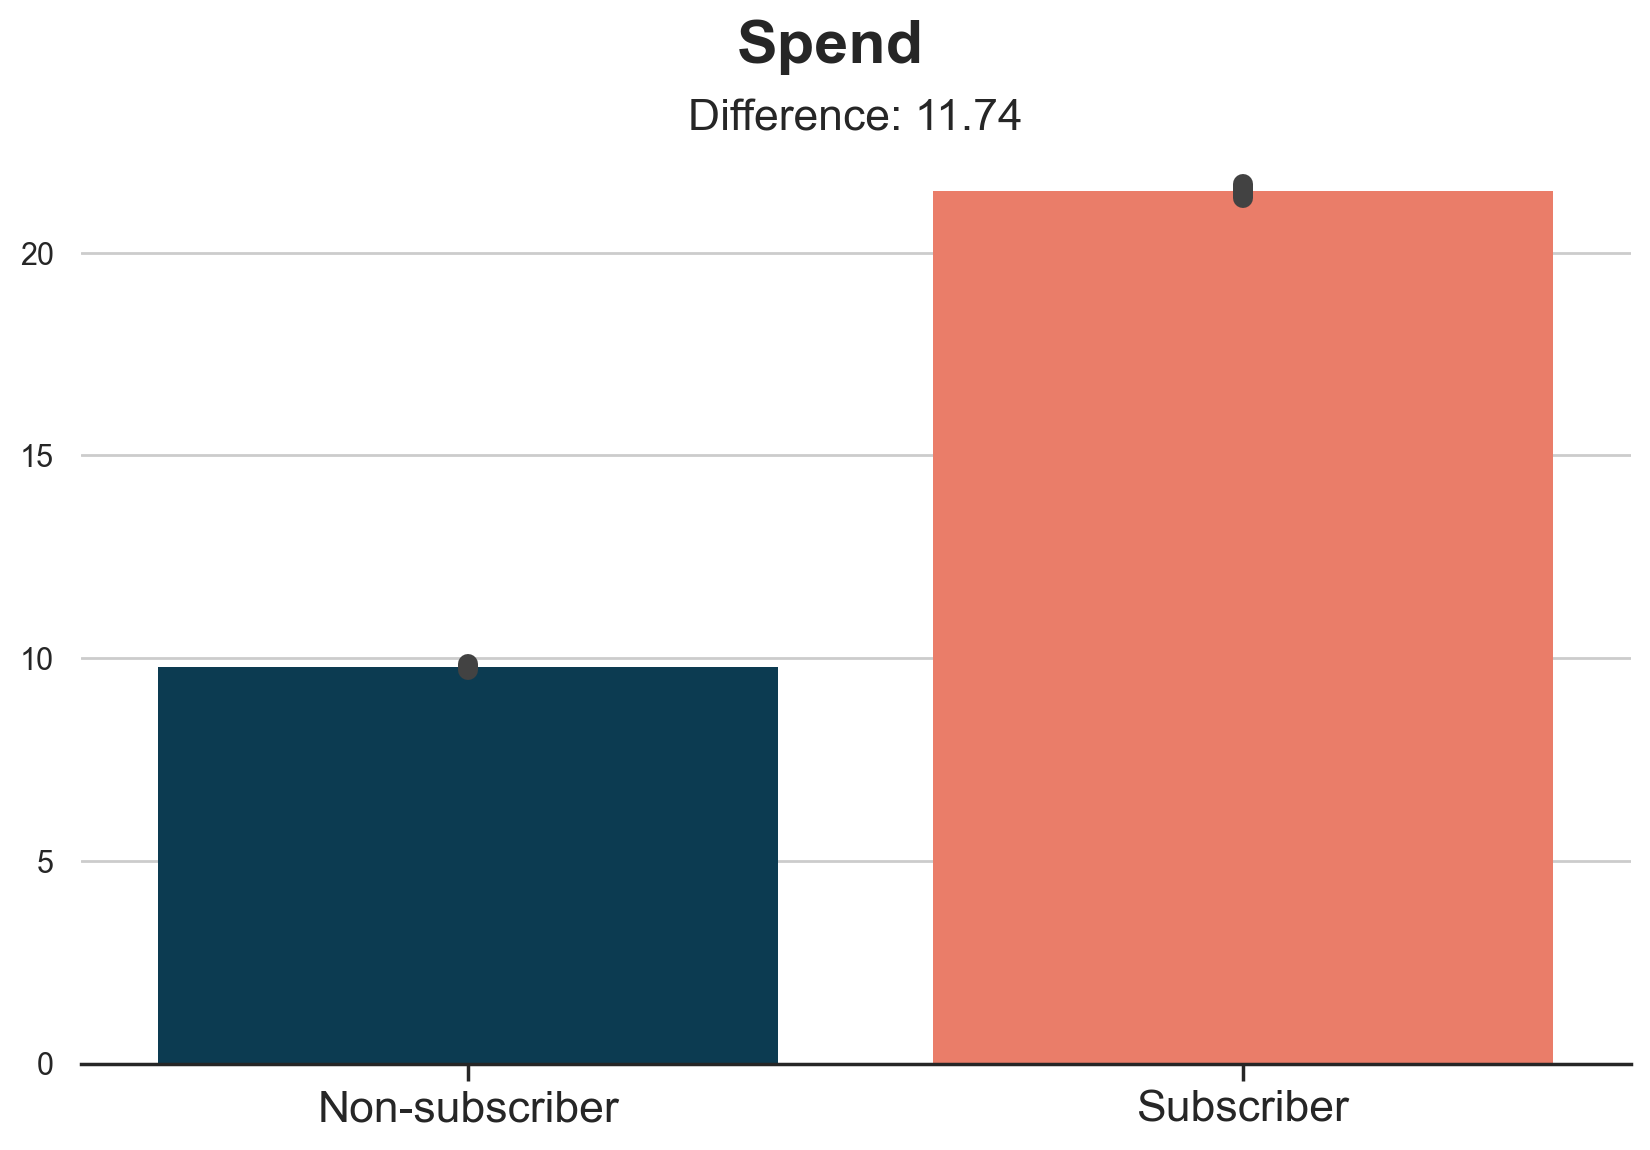

In [85]:
plot_group_comparison(df, x="subscribe", y="spend", title="Spend", xticks=["Non-subscriber", "Subscriber"])

Subscribers seem to be much more likely to spend money on our platform. But is it really the case?

We can imagine that customers that are most interested in the program are also the first to subscribe to the newsletter. 

We can represent the relationship between the variables in the following Dyrected Acyclic Graph (DAG).

```mermaid
flowchart LR
classDef included fill:#DCDCDC,stroke:#000000,stroke-width:2px;
classDef excluded fill:#ffffff,stroke:#000000,stroke-width:2px;

U((interest))
X((subscribe))
Y((buy))

U --> X
U --> Y
X --> Y

class X,Y included;
class U excluded;
```

In [91]:
def show_results(table):
    df = pd.DataFrame(table)
    new_header = df.iloc[0] #grab the first row for the header
    df = df[1:] #take the data less the header row
    df.columns = new_header
    df = df.set_index(df.columns[0])
    return df

In [92]:
ols_model = smf.ols("spend ~ subscribe", data=df).fit()
show_results(ols_model.summary().tables[1])

,coef,std err,t,P>|t|,[0.025,0.975]
,,,,,,
Intercept,9.7867,0.038,256.404,0.000,9.712,9.862
subscribe,11.7387,0.108,108.472,0.000,11.527,11.951


## Experimental Design

Unfortunately, we cannot force people to subscribe to the newsletter. However, we can **encourage** people to subscribe. For example, we can send them an **email** to remind them. This setting is called an encouragement design.

![img](fig/instrumental_variables1.png)


With the encouragement, the data generating process can be represented with the following DAG.

```mermaid
flowchart LR
classDef included fill:#DCDCDC,stroke:#000000,stroke-width:2px;
classDef excluded fill:#ffffff,stroke:#000000,stroke-width:2px;

U((interest))
Z((mail))
X((subscribe))
Y((buy))

U --> X
U --> Y
Z --> X
X --> Y

class Z,X,Y included;
class U excluded;
```

Strictly speaking, now we have closed the open path between `subscription` and `buy`. Therefore, we can not estimate the causal effect of the subscription on the probability of making a sale.

Was the `notification` effective? Thanks to randomization, we can attribute the average difference in `spend` between people that received the `notification` and people that did not, to the treatment itself.

$$
\mathbb{E} \Big[ \text{spend} \ | \ \text{notification} = 1 \Big] - \mathbb{E} \Big[ \text{spend} \ | \ \text{notification} = 0 \Big]
$$

If we compute this difference in means, it looks like the notification has increase `spend` by roughly *1€* per customer.

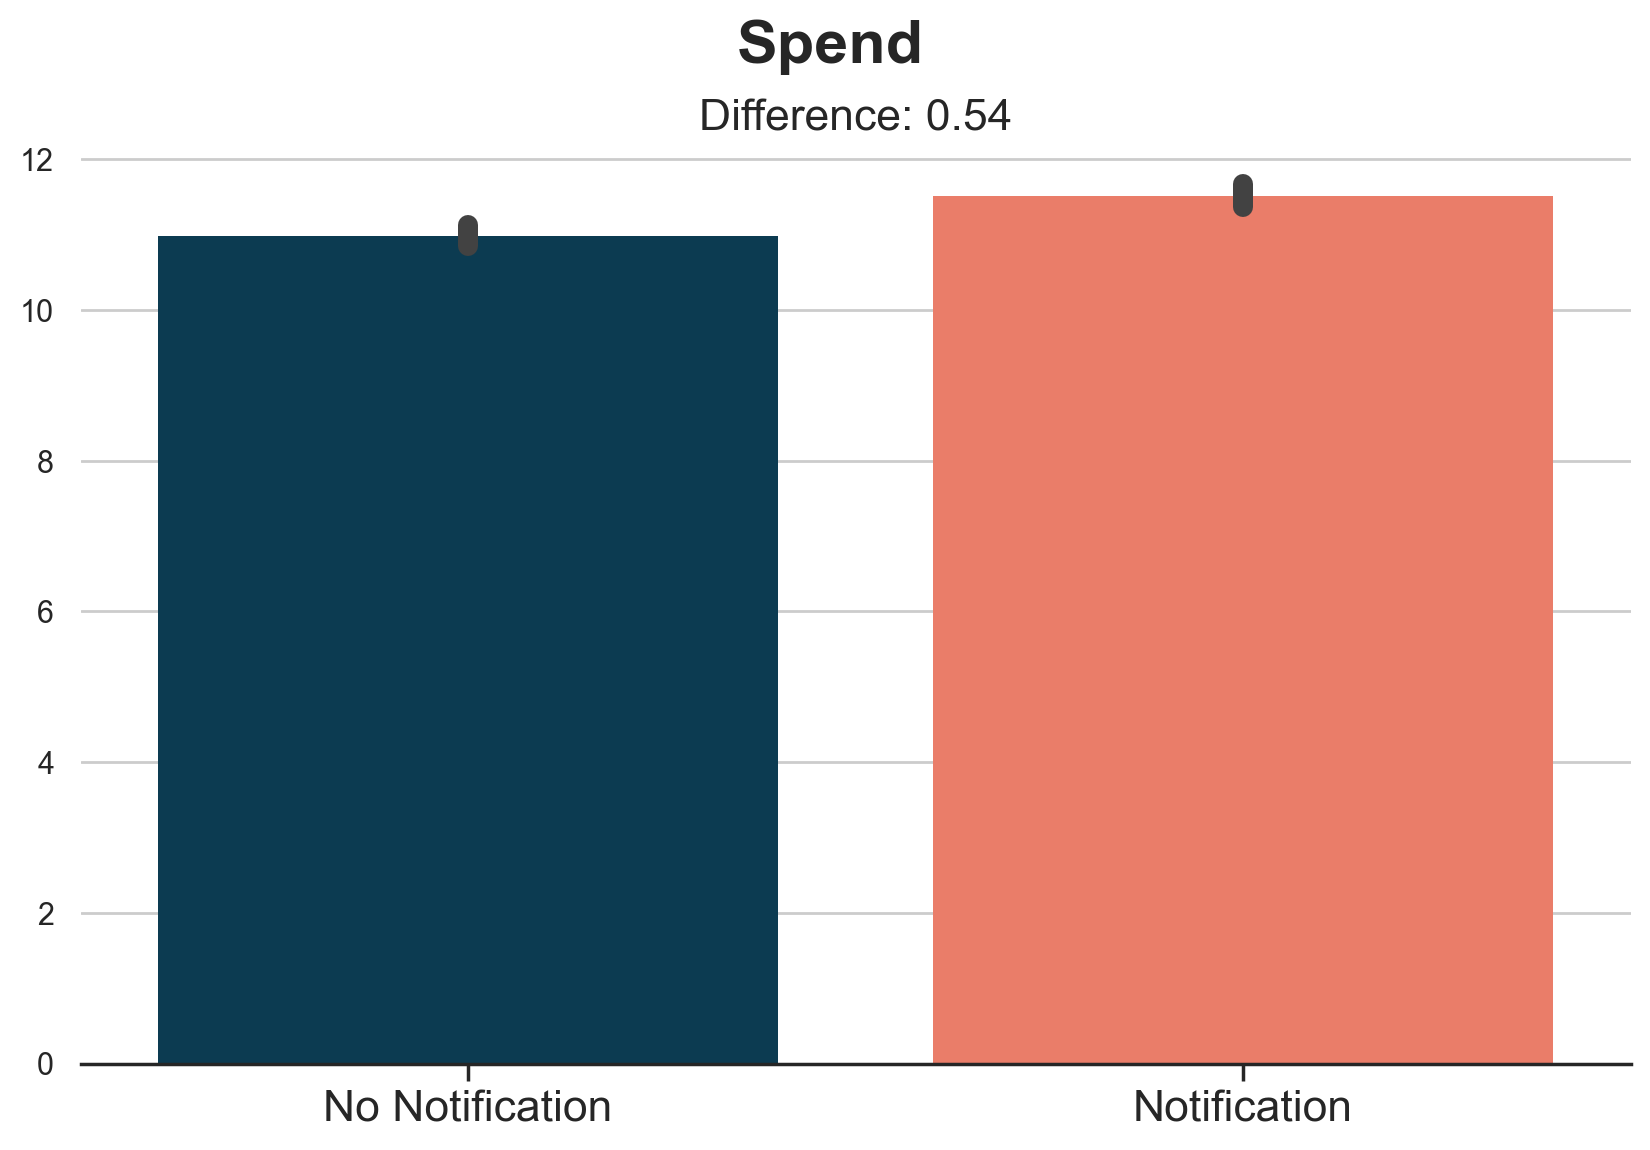

In [93]:
plot_group_comparison(df, x="notification", y="spend", title="Spend", xticks=["No Notification", "Notification"])

However, the effect of the `notification` on `spend` is not what we are interested in. We would rather know the effect of the `subscription` on `spend`. In fact, not all people that receive the email subscribe to the newletter. And viceversa, some people subscribe to the newsletter even without the notification. 

This means that the effect that we have just computed is **diluted** by the fact that some people do not comply with our incentive, the `notification`. We have to attribute it *only* to the customers that changed their mind because of the newsletter. How many are these customers?

Let's compute the probability of `subscription`, by treatment group. 

$$
\mathbb{E} \Big[ \text{subscription} \ | \ \text{notification} = 1 \Big] - \mathbb{E} \Big[ \text{subscription} \ | \ \text{notification} = 0 \Big]
$$

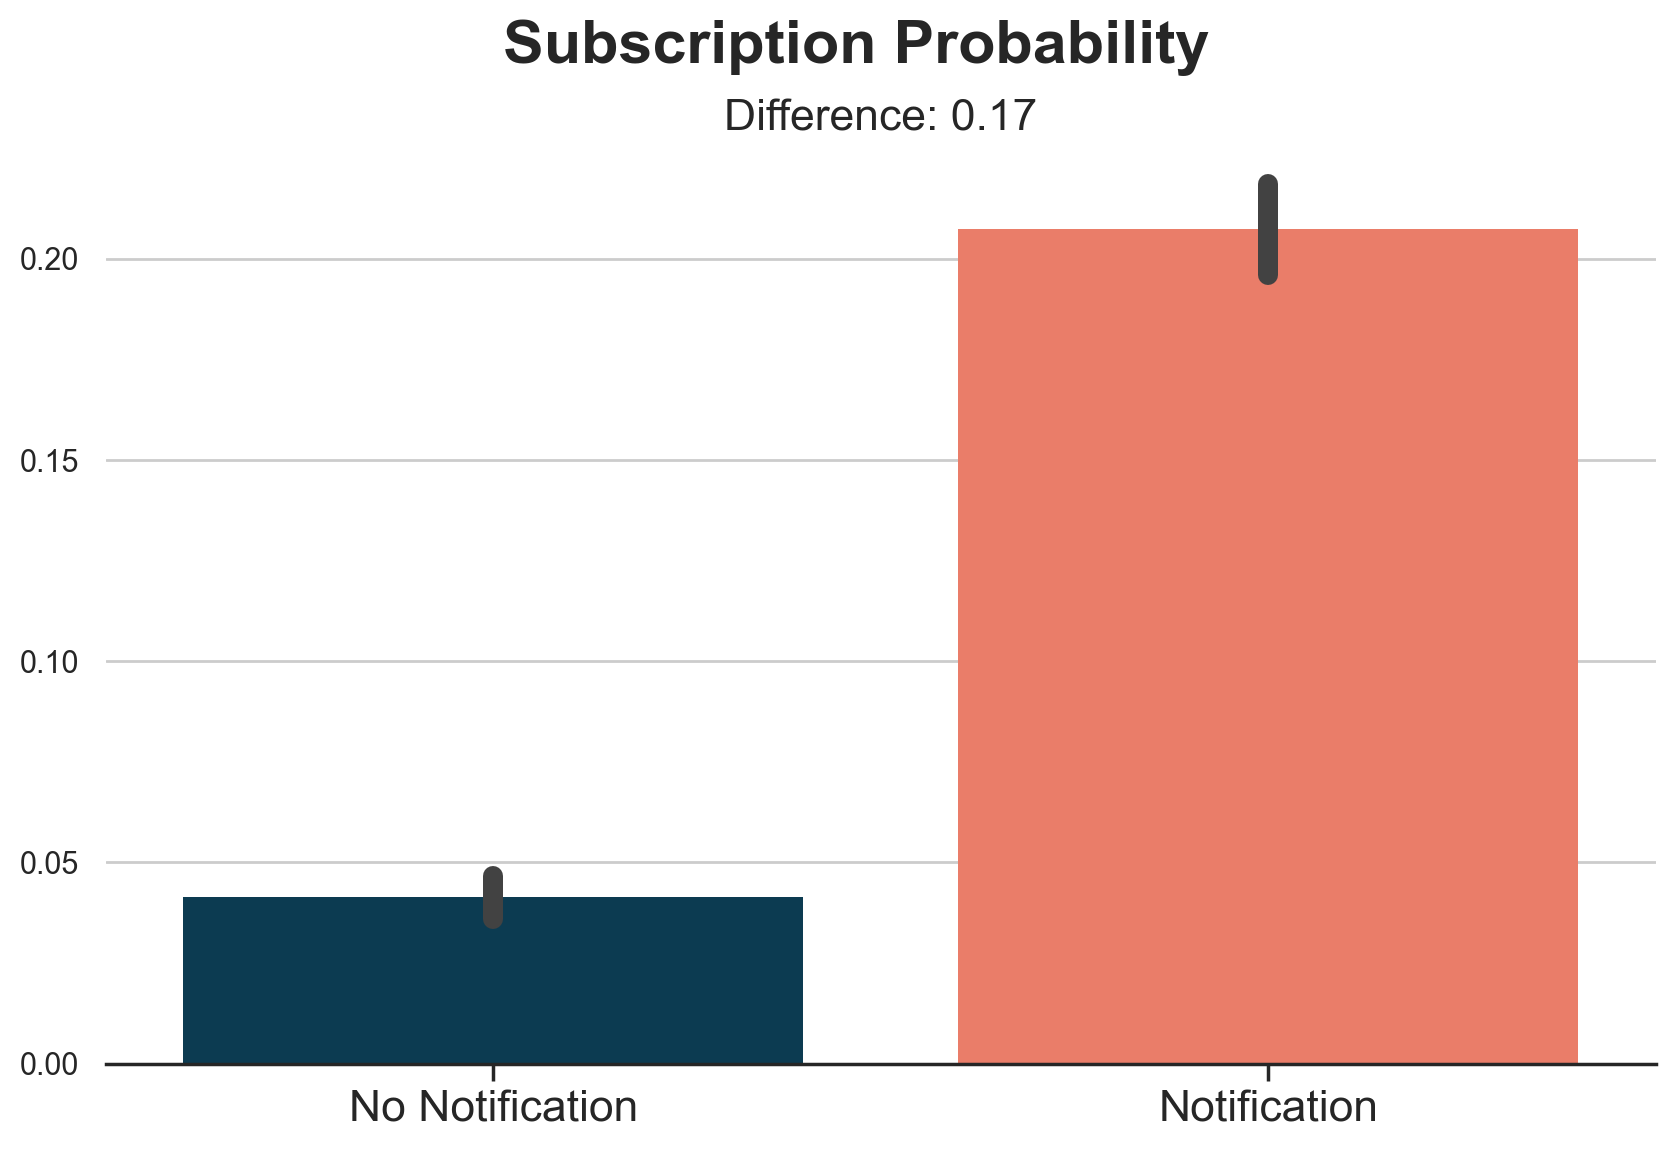

In [94]:
plot_group_comparison(df, x="notification", y="subscribe", title="Subscription Probability", xticks=["No Notification", "Notification"])

Customers that received the `notification` have a *21%* higher `subscription` probability. In other words, it seems that the `notification` is able to make *21%* of our customers change their mind. From the control group, we learn that *38%* of them would have subscribed anyways, while the remaining *41%* we are unable to convince. 

Therefore, we should consider that only *21%* of customers are responsible the effect of the `notification` on `spend`, of 

## Intuition

In this case, with a binary instrument, the `notification`, a binary treatment, the `subscription` decision, and a 50-50 assignment probability, we can get a very simple intuition of how instrumental variables work.

We have four groups of customers, depending on whether they received the notification or not, and wether they subscribed or not.

In [112]:
df.groupby(["notification", "subscribe"]).agg(spend=("spend", "sum"), customers=("spend", "count")).iloc[::-1].T.round(0)

notification        1                0         
subscribe           1        0       1        0
spend         21505.0  36074.0  5273.0  49618.0
customers      1037.0   3963.0   207.0   4793.0

![img](fig/instrumental_variables2.png)

Comparing treatment (`notification`) and control group, we see that the notification has generated an increase in `spend` of *2.7k€*. In order to recover the causal effect of interest, we just need to attribute the *2.7k€* incremental `spend` to the *800* customers that decided to `subscribe` because of the `notification`. The result is exactly *3.2€* per customer!

![img](fig/instrumental_variables3.png)

## IV Algebra

In [ ]:
from linearmodels.iv.model import IV2SLS as iv

In [104]:
model_iv = iv.from_formula("spend ~ 1 + [subscribe ~ notification]", data=df).fit()
show_results(model_iv.summary.tables[1])

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
,,,,,,
Intercept,10.844,0.0824,131.55,0.0000,10.683,11.006
subscribe,3.2375,0.5472,5.9168,0.0000,2.1651,4.3100


In [101]:
model_fs = smf.ols("subscribe ~ notification", data=df).fit()

In [102]:
df["subscribe_hat"] = model_fs.predict(df)

In [103]:
show_results(smf.ols("spend ~ subscribe_hat", data=df).fit().summary().tables[1])

,coef,std err,t,P>|t|,[0.025,0.975]
,,,,,,
Intercept,10.8442,0.095,114.363,0.000,10.658,11.030
subscribe_hat,3.2375,0.634,5.106,0.000,1.995,4.480
